To solve the risk budgeting problem, we'll start by doing very simple and native risk budgeting strategies. We'll see that it helps, but it is really not solving the fundamental problem of meeting our liabilities. We'll start with something simple by figuring out how to write allocators, how to write strategies, how to backtest strategies that construct portfolios that mix PSP and GHP in some sort of systematic way.  

In [1]:
import numpy as np
import pandas as pd
import risk_kit as kit
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# Backtester to test different mixes between two different portfolios from returns
def backtest_mix(r1, r2, allocator, **kwargs):
    """
    Runs a back test (simulation) of allocating between two sets of returns.
    r1 and r2 are T*N DataFrames or returns where T is the time step index and 
    N is the number of scenarios.
    allocator is a function that takes two sets of returns and allocator specific parameters.
    and produces an allocation to the first portfolio (the rest of the money is invested 
    in the GHP) as a T*1 DataFrame.
    Returns a T*N DataFrame of the resulting N portfolio scenarios.
    """
    
    if not r1.shape == r2.shape:
        raise ValueError("r1 and r2 need to be the same shape")
        
    weights = allocator(r1, r2, **kwargs)
    
    if not weights.shape == r1.shape:
        raise ValueError("Allocator returned weights that don't match r1")
        
    r_mix = weights*r1 + (1-weights)*r2
    return r_mix
    
    

In [3]:
# Write a simpe allocator
def fixed_mix_allocator(r1, r2, w1, **kwargs):
    """
    Produces a time series over T steps of allocations between the PSP and GHP across N scenarios.
    PSP and GHP are T*N DataFrames that represent the returns of the PSP and GHP such that:
        - each column is a scenario
        - each row is the price for a timestep.
    Returns an T*N DataFrame of PSP weights.
    """
    # same mix every single time
    return pd.DataFrame(data=w1, index= r1.index, columns=r1.columns)

In [4]:
# From Monte-Carlo simulation 

# Get rates and 500 scenarios for zero-coupon prices for a bond with 10 year maturity, 500 scenarios
rates, zc_prices = kit.cir(10, 500, b=0.03, r_0=0.03)
price_10 = kit.bond_price(10, 100, .05, 12, rates)
price_30 = kit.bond_price(30, 100, .05, 12, rates)
# Compute Returns
returns_30 = kit.bond_total_return(price_30, 100, .05, 12)
returns_10 = kit.bond_total_return(price_10, 100, .05, 12)

# Call fixed mix allocator, with the two sets of returns. 
# Backtest the mixer giving it the returns of 10 and 30 year bond returns 
returns_bonds = backtest_mix(returns_10, returns_30, allocator=fixed_mix_allocator, w1=0.6)
# calculate composite of the bonds and compute the stats of the composite.
mean_rets_bonds = returns_bonds.mean(axis='columns')
kit.summary_stats(pd.DataFrame(mean_rets_bonds))

,Annualied Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
0,0.035519,0.003534,0.294926,3.625019,-0.001342,-0.000762,1.519785,0.0


In [5]:
# Generate some Equity returns
price_equity = kit.gbm(n_years=10, n_scenarios=500, mu=0.07, sigma=0.15)
returns_equity =  price_equity.pct_change().dropna()

# Compute the returns of zero-coupon bond. 
returns_zerocoupon = zc_prices.pct_change().dropna()

It is ok to do this because the price return of a zero-coupon bond is the total return of a zero-coupon bond because it doesn't pay coupons.

In [6]:
# Now I can construct a portfolio which is a composite of 70-30 
# 70% in PSP
returns_7030bond = backtest_mix(returns_equity, returns_bonds, allocator=fixed_mix_allocator, w1=0.7)
returns_7030bond_mean_return = returns_7030bond.mean(axis=1)
kit.summary_stats(pd.DataFrame(returns_7030bond_mean_return))

,Annualied Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
0,0.060017,0.005388,-0.083729,2.355636,-0.002266,-0.001784,5.422681,0.0


This tells us that the annualized return here is higher than the return you would get with just a 
60-40 bond mix. 

If you have the money to buy zero-coupon bonds or do a full duration matched bond portfolio to the duration of your liabilities and you can get the funding ratio of 100%, you are good. You have the money that you need so just move everything to bonds and stop taking any further risk. But if you don't have the money, you are going to have to put some money in the PSP and this thing is showing exactly what would happen. The more money you put into your PSP, the more your annualized return is going to be and so better chance that you hit your liabilities. 

In [7]:
# Another - better way of doing the same thing as above
summaries = kit.summary_stats(returns_7030bond)
summaries.head()

,Annualied Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
0,0.097028,0.104801,-0.059554,2.846941,0.041958,0.054170,0.622387,-0.117293
1,0.090093,0.114882,0.132335,2.807892,0.045441,0.054528,0.508992,-0.124688
2,0.048523,0.103696,-0.048370,2.579693,0.045294,0.054032,0.173729,-0.191818
3,0.026935,0.123805,-0.027570,2.613961,0.056246,0.068448,-0.024249,-0.240313
4,0.073161,0.114640,-0.097732,2.205520,0.049203,0.053215,0.366299,-0.131993


In [8]:
summaries.mean()

Annualied Return           0.054470
Annualized Vol             0.107753
Skewness                   0.005894
Kurtosis                   2.930638
Cornish-Fisher VaR (5%)    0.046044
Historic CVaR (5%)         0.057968
Sharpe Ratio               0.223900
Max Drawdown              -0.209439
dtype: float64

The first method computes one time series which is the average of all the 500 different possible scenarios and then computes the summary stats on that average case.


The second method calculates each statistic for every one of those 500 different scenarios and computes the average across those statistics.

Both of these are not the proper way to do this, these are shortcuts, but it tells you how the returns work.The annualized returns are going to be higher.


The proper way is to look at terminal values. At the end of the period, how much cash do you have?

In [9]:
def terminal_values(rets):
    """
    Returns the final values (of a dollar) at the end of the return period for each scenario.
    """
    # It is nothing more than the compounded return.
    return (rets+1).prod()

In [10]:
def terminal_stats(rets, floor=0.8, cap=np.inf, name="Stats"):
    """
    Produce summary statistics on the terminal values per invested dollar across a range of N scenarios.
    rets is a T*N DataFrame of return, where T is the time-step (we assume returns are sorted by time).
    Returns a 1 column DataFrame of Summary Stats indexed by the stats name.
    """
    terminal_wealth = (rets+1).prod()
    breach = terminal_wealth < floor
    reach = terminal_wealth >= cap
    p_breach = breach.mean() if breach.sum() > 0 else np.nan
    p_reach = breach.mean() if reach.sum() > 0 else np.nan
    e_short = (floor - terminal_wealth[breach]).mean() if breach.sum() > 0 else np.nan
    e_surplus = (cap - terminal_wealth[reach]).mean() if reach.sum() > 0 else np.nan
    sum_stats = pd.DataFrame.from_dict({
        "mean": terminal_wealth.mean(),
        "std": terminal_wealth.std(),
        "p_breach": p_breach,
        "e_short": e_short,
        "p_reach": p_reach,
        "e_surplus": e_surplus
    }, orient="index", columns=[name])
    return sum_stats


In [11]:
pd.concat([
            terminal_stats(returns_bonds, name="FI"),
            terminal_stats(returns_equity, name="Eq"),
            terminal_stats(returns_7030bond, name="70/30"),
          ], axis=1)

,FI,Eq,70/30
mean,1.378784,1.965515,1.781038
std,0.114169,0.964952,0.596266
p_breach,NaN,0.044000,0.008000
e_short,NaN,0.108763,0.060852
p_reach,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN


It says that, across those 500 scenarios that we tested, 
    - the mean case here is, if you invest in the fixed income strategy, that's 40/60, between the short and long bond (10 and 30 year bond) you'll end up with $1.38.
    
    - for equities you'll end up with $1.97 and for 70/30 you'll end up with 1.78
    
I have set my floor at 80%. If you think of .8 as your liability.

Floor is the number I do not want to be below. The minimum acceptable liability in the goal based investing paradigm, essentially what they call the minimum essential goal.

I started with a dollar. This says that for every dollar, you'll end up with 1.38$ and the probability that you'll end up below 0.8 is zero [p_breach was not a significant number]. That is the beauty of fixed income: the at you tend not to lose that kind of money over a period of 10 years; with the long bond you might end up below.

*Equities*

If you look at equities, equities gave you much greater shot at your upside. The problem was that you got a 5.8% chance that you will end up below

### CHECK THIS

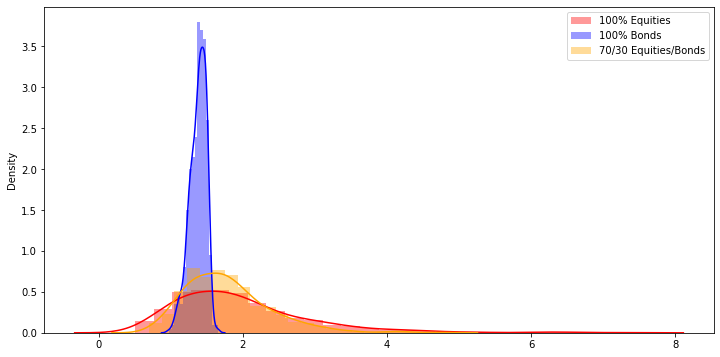

In [12]:
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
sns.distplot(kit.terminal_values(returns_equity), color="red", label="100% Equities")
sns.distplot(kit.terminal_values(returns_bonds), color="blue", label="100% Bonds")
sns.distplot(kit.terminal_values(returns_7030bond), color="orange", label="70/30 Equities/Bonds")
plt.legend()

If you look at the point of 0.8, there is still a significant mass above it, meaning with the 100% equities or even with 70/30 version, there is a significant probability of ending up below it. *This is what we want to eliminate.*


Instead of fixed mix, if you think risk as time, as you get to the end of your time period, you move to bonds. This is the basic idea behind **Target date fund**.

### Glide Paths for Allocation

In [13]:
# Start out with something like 80-90% in stocks 
# and then glide the way to a glide path over those 10 years
# glide from 100% to 0% by default
def glidepath_allocator(r1, r2, start_glide=1, end_glide=0):
    """
    Simulates a Target-Date-Fund style gradual move from r1 to r2.
    """
    n_points = r1.shape[0]
    n_column = r1.shape[1]
    glide_path = pd.Series(data=np.linspace(start_glide, end_glide, num=n_points))
    # we need to return as many columns as r1
    paths = pd.concat([glide_path]*n_column, axis=1)
    paths.index = r1.index
    paths.columns = r1.columns
    return paths

In [14]:
returns_glidepath8020 = kit.backtest_mix(returns_equity, returns_bonds,
                            allocator=glidepath_allocator, start_glide=.80, end_glide=.20)
pd.concat([
            terminal_stats(returns_bonds, name="FI"),
            terminal_stats(returns_equity, name="Eq"),
            terminal_stats(returns_7030bond, name="70/30"),
            terminal_stats(returns_glidepath8020, name="Glide 80 to 20")
          ], axis=1)

,FI,Eq,70/30,Glide 80 to 20
mean,1.378784,1.965515,1.781038,1.674026
std,0.114169,0.964952,0.596266,0.425914
p_breach,NaN,0.044000,0.008000,0.002000
e_short,NaN,0.108763,0.060852,0.023034
p_reach,NaN,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN,NaN


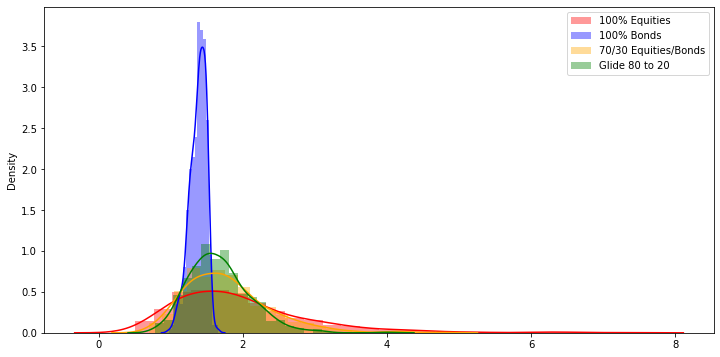

In [15]:
plt.figure(figsize=(12,6))
sns.distplot(kit.terminal_values(returns_equity), color="red", label="100% Equities")
sns.distplot(kit.terminal_values(returns_bonds), color="blue", label="100% Bonds")
sns.distplot(kit.terminal_values(returns_7030bond), color="orange", label="70/30 Equities/Bonds")
sns.distplot(kit.terminal_values(returns_glidepath8020), color="green", label="Glide 80 to 20")
plt.legend()

We can see that this glide path allocator doesn't really solve the problem. You still get breaches. The glide paths very seldom produce superior results.

We could try making a portfolio with equities and zero-coupon bonds, but you'llfind that it really doesn't hep in solving the breaching problem.